# Bell states and noise

Import packages:

In [31]:
%matplotlib inline
import random as rnd
import numpy as np
from qiskit import QuantumCircuit, Aer, assemble, execute
from qiskit.visualization import array_to_latex, plot_histogram
import qiskit.providers.aer.noise as aer_noise
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter

Defining new LaTeX commands for bra and ket vectors...
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Generating Bell states and ideal simulations

Here we try to generate 'maximally' entangled quantum states. For 2-qubit case these are the Bell states and for more qubits, they are known as GHZ states.

### Basic Bell states

To generate Bell states we can use the CNOT gate with control qubit being in superposition state after the Hadamard gate. Here, we generate the state $$\frac{1}{\sqrt{2}}(\ket{00} + \ket{11}).$$

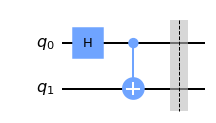

In [2]:
sim = Aer.get_backend('aer_simulator')

qc2 = QuantumCircuit(2)

#qc2.x(0) # Uncomment to generate other Bell states
#qc2.x(1)

qc2.h(0) # Hadamard gate on control qubit
qc2.cx(0, 1) # CNOT with control qubit 0 and target 1
qc2.save_statevector()
qc2.draw('mpl')

Below we show the results from an ideal simulator:

In [3]:
qobj2 = assemble(qc2)
result2 = sim.run(qobj2).result()
array_to_latex(result2.get_statevector(), prefix='Final state = ')

<IPython.core.display.Latex object>

In [4]:
qc2.measure_all()

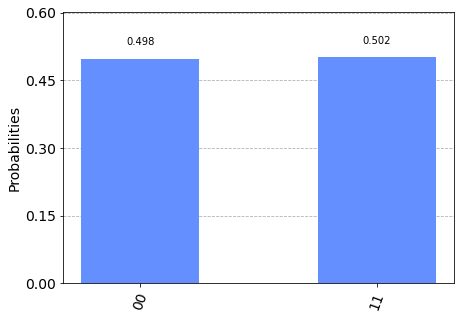

In [5]:
qobj2 = assemble(qc2)
result2 = sim.run(qobj2).result()
plot_histogram(result2.get_counts())

### Bell states on multiple qubits

Let's try to prepare Bell states with more than two qubits (a maximally entagled state, also called GHZ states). For 3 qubits, we want
$$\frac{1}{\sqrt{2}}(\ket{000} + \ket{111}).$$ <br />We can achieve this by first preparing a standard Bell state on first two qubits. The state of 3 qubits is then $\frac{1}{\sqrt{2}}(\ket{000} + \ket{011})$. Thus, we need to flip 3rd qubit if the 2nd qubit is 1 and do nothing otherwise. This is done by the CNOT gate with 3rd qubit as the target and 2nd as the control:

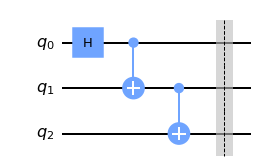

In [6]:
qc3 = QuantumCircuit(3)

# qc3.x(0) # Uncomment to generate other entangled states
# qc3.x(1)
# qc3.x(2)

qc3.h(0) # Hadamard gate on control qubit
qc3.cx(0, 1) # CNOT with control qubit 0 and target 1
qc3.cx(1, 2) # CNOT with control qubit 1 and target 2
qc3.save_statevector()
qc3.draw('mpl')

Below we show the results from an ideal simulator:

In [7]:
qobj3 = assemble(qc3)
result3 = sim.run(qobj3).result()
array_to_latex(result3.get_statevector(), prefix='Final state = ')

<IPython.core.display.Latex object>

In [8]:
qc3.measure_all()

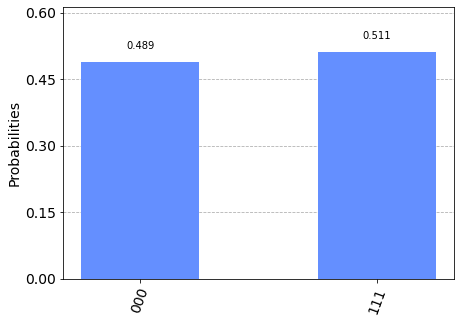

In [9]:
qobj3 = assemble(qc3)
result3 = sim.run(qobj3).result()
plot_histogram(result3.get_counts())

Now, we can notice that adding a fourth qubit with CNOT controlled by the 3rd qubit will again create a similar state:

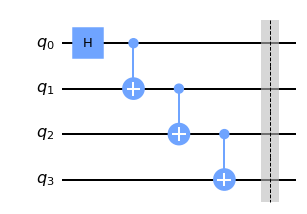

In [10]:
qc4 = QuantumCircuit(4)

#qc4.x(0) # Uncomment to generate other entagled states
#qc4.x(1)
#qc4.x(2)
#qc4.x(3)

qc4.h(0) # Hadamard gate on control qubit
qc4.cx(0, 1) # CNOT with control qubit 0 and target 1
qc4.cx(1, 2) # CNOT with control qubit 1 and target 2
qc4.cx(2, 3)
qc4.save_statevector()
qc4.draw('mpl')

Below we show the results from an ideal simulator:

In [11]:
qobj4 = assemble(qc4)
result4 = sim.run(qobj4).result()
array_to_latex(result4.get_statevector(), prefix='Final state = ')

<IPython.core.display.Latex object>

In [12]:
qc4.measure_all()

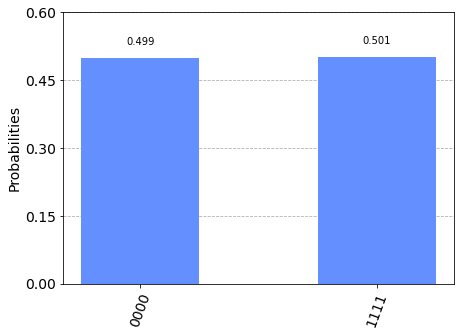

In [13]:
qobj4 = assemble(qc4)
result4 = sim.run(qobj4).result()
plot_histogram(result4.get_counts())

We can continue doing this to generate 'maximally' entangled states of this form for an arbitrary number of qubits.

## Adding noise to Bell states

Noise can be modelled in Qiskit by adding the QuantumError objects to each of the used gates. We add the following errors:

- When using Hadamard gate, there is a 5% chance that the qubit will be reset to $\ket{0}$ and 5% for resetting to $\ket{1}$.

- When using the CNOT gate a 2-qubit error is applied that is a tensor product of the resetting error defined above.

- Readout error is added on every qubit, so that there is 5% chance of reading a different value than the ideal measurement would do.

In [14]:
prob_err_H = 0.05
prob_err_readout = 0.05
prob_mat_err_readout = np.full((2, 2), prob_err_readout)
for i in range(len(prob_mat_err_readout)):
    prob_mat_err_readout[i, i] = 1 - prob_err_readout

In [15]:
error_H = aer_noise.reset_error(prob_err_H, prob_err_H)
error_CNOT = error_H.tensor(error_H)
error_readout = aer_noise.ReadoutError(prob_mat_err_readout)

Here we add these errors to the noise model for the Aer simulator.

In [16]:
noise_model = aer_noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_H, ['h'])
noise_model.add_all_qubit_quantum_error(error_CNOT, ['cx'])
noise_model.add_all_qubit_readout_error(error_readout)

We need to get the new basis gates that incorporate our errors.

In [17]:
basis_gates = noise_model.basis_gates

### Bell states with noise

We perform the simulation using the noisy gates on the circuit to generate 2-qubit Bell states.

In [18]:
if qc2.data[2][0].name == 'save_statevector':
    qc2.data.pop(2) # Deletes the save_statevector 'gate'

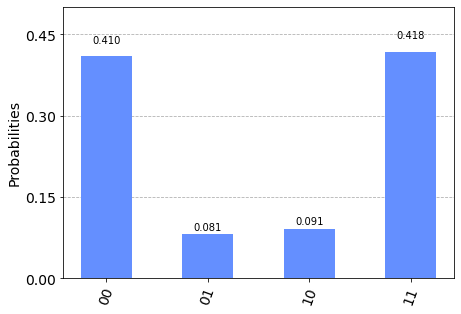

In [19]:
result2_noisy = execute(qc2, Aer.get_backend('aer_simulator'),
                basis_gates=basis_gates,
                noise_model=noise_model).result()
plot_histogram(result2_noisy.get_counts())

We can see that due to noise some 'new' mixed states appear, that are not part of our entangled Bell state ($\ket{01}$ and $\ket{10}$) with probability a little below 10% each. It might not be obvious now that the circuit should output an entangled state.

### GHZ states with noise

Next we perform the simulation using the noisy gates on the circuit to generate 4-qubit entangled GHZ states.

In [20]:
if qc4.data[4][0].name == 'save_statevector':
    qc4.data.pop(4) # Deletes the save_statevector 'gate'

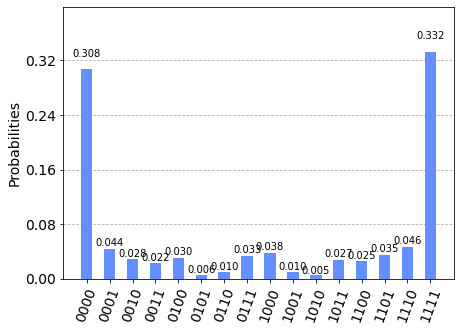

In [21]:
result4_noisy = execute(qc4, Aer.get_backend('aer_simulator'),
                basis_gates=basis_gates,
                noise_model=noise_model).result()
plot_histogram(result4_noisy.get_counts())

Again due to noise some other states appear, that are not part of the entangled state with differing probabilities, but not exceeding roughly 5%. It is not obvious that the circuit produces an entangled state, however the correct states seem to be pretty well distinguishable and the rest looks like background noise.

### 4-qubit simulation on real hardware

The code below submits a job to a physical quantum computer from IBM:

In [22]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

The account is already saved with a corect token.

In [23]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Here we choose a backend with 5 qubits that has the smallest queue:

In [24]:
provider = IBMQ.get_provider(hub='ibm-q')
five_q_devices = provider.backends(simulator=False, operational=True,
                  filters=lambda x: x.configuration().n_qubits == 5)
backend = least_busy(five_q_devices)
print("Least busy 5-qubit device is:", backend)
backend.status()

Least busy 5-qubit device is: ibmq_manila


Execute the job and show the results:

In [25]:
job = execute(qc4, backend, shots=1024)
job.update_name("four_qubit_bell_state")

'four_qubit_bell_state'

In [26]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [ ]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

The noise levels are much lower than in our noisy simulation. However, there is a significant probability for the $\ket{1110}$ state, which is probably device-specific.

# Measurement error mitigation

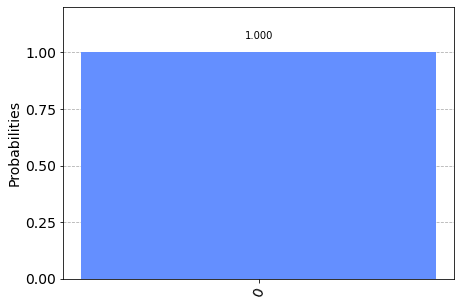

In [170]:
sim = Aer.get_backend('aer_simulator')

qc = QuantumCircuit(1)

qc.measure_all()

qobj = assemble(qc)
result = sim.run(qobj, shots=10000).result()
plot_histogram(result.get_counts())

In [171]:
p = 0.1
measurement_error = aer_noise.errors.pauli_error([('X', p), ('I', 1 - p)])

noise_model = aer_noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(measurement_error, 'measure')

basis_gates = noise_model.basis_gates

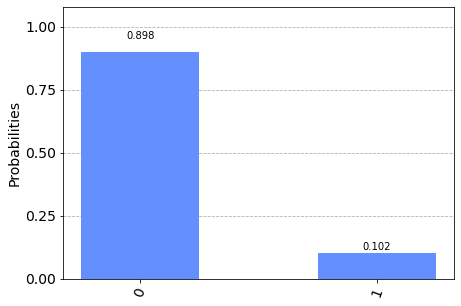

In [172]:
result_noisy = execute(qc, Aer.get_backend('aer_simulator'), shots=10000,
                basis_gates=basis_gates,
                noise_model=noise_model).result().get_counts()
plot_histogram(result_noisy)

In [173]:
for state in ['0', '1']:
    qc_test = QuantumCircuit(1)
    if state=='1':
        qc_test.x(0)
    qc_test.measure_all()
    qobj_test = assemble(qc_test)
    counts = sim.run(qobj_test, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

0 becomes {'0': 9022, '1': 978}
1 becomes {'1': 9049, '0': 951}


In [182]:
import scipy.linalg as la

M = [[0.9022, 0.0978], [0.0951, 0.9049]]

M_inv = la.inv(M)

display(array_to_latex(M, prefix='M = '))
display(array_to_latex(M_inv, prefix='M^{-1} = '))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

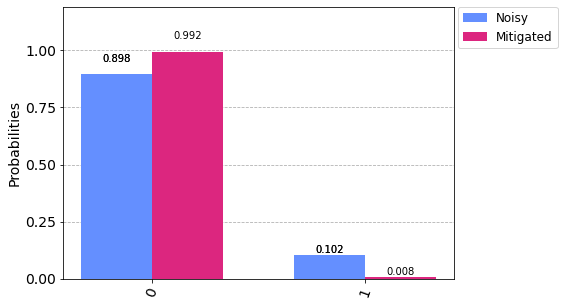

In [177]:
result_noisy_vector = np.c_[list(result_noisy.values())]
result_mitigated_vector = np.dot(M_inv, result_noisy_vector)
result_mitigated = {}
result_mitigated['0'] = result_mitigated_vector[0][0]
result_mitigated['1'] = result_mitigated_vector[1][0]
plot_histogram([result_noisy, result_mitigated], legend=['Noisy', 'Mitigated'])